<a href="https://colab.research.google.com/github/64060kbarot/AML_64061/blob/main/Assignment2_Convolution_Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Assignment 2: Convolutional***

In this assignment, you will examine the relationship between training samples and the choice
of training your model from scratch, versus using a pretrained convnet. Specifically, answer the
following questions:
1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a
validation sample of 500, and a test sample of 500 (like in the text). Use any technique
to reduce overfitting and improve performance in developing a network that you train
from scratch. What performance did you achieve?
2. Increase your training sample size. You may pick any amount. Keep the validation and
test samples the same as above. Optimize your network (again training from scratch).
What performance did you achieve?
3. Now change your training sample so that you achieve better performance than those
from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous
steps. The objective is to find the ideal training sample size to get best prediction
results.
4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in
Steps 2 and 3 for the pretrained network may be the same or different from those using
the network where you trained from scratch. Again, use any and all optimization
techniques to get best performance.


In [1]:
#Loading all the required libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import zipfile
import io
import os
import shutil
import pathlib
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from io import BytesIO
from zipfile import ZipFile

In [2]:
#Importing the JSON Activation Code
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kandarpbarot1","key":"c1bf2d39039029bd384fc0e6e6a98267"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
#Downloading the Data
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -o -qq dogs-vs-cats.zip

In [6]:
!unzip -o -qq train.zip

In [7]:
!pip install tensorflow==2.12

# ***1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?***

In [8]:
import os, shutil, pathlib
#shutil.rmtree("cats_vs_dogs_small/train/cat")

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok = True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [9]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [10]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


*Model_MaxPooling_filter32_512_Layer5*

In [11]:
#Building the model
#Instantiating a small convnet for dogs vs. cats classification
#*Model - 1 MaxPooling Operation with Increase in filters from 32 to 256 in 5 Input Layers*

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [13]:
# Compilimg the results of the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Fitting/Running the Model
Model_1 = model.fit(
          train_dataset,
          epochs= 20,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/20
32/32 [==============================] - 27s 809ms/step - loss: 0.7063 - accuracy: 0.4840 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 26s 815ms/step - loss: 0.6936 - accuracy: 0.5100 - val_loss: 0.6916 - val_accuracy: 0.5040
Epoch 3/20
32/32 [==============================] - 27s 832ms/step - loss: 0.6911 - accuracy: 0.5560 - val_loss: 0.6849 - val_accuracy: 0.6060
Epoch 4/20
32/32 [==============================] - 26s 799ms/step - loss: 0.6850 - accuracy: 0.5580 - val_loss: 0.6902 - val_accuracy: 0.5120
Epoch 5/20
32/32 [==============================] - 27s 845ms/step - loss: 0.6884 - accuracy: 0.5560 - val_loss: 0.6788 - val_accuracy: 0.5440
Epoch 6/20
32/32 [==============================] - 25s 788ms/step - loss: 0.6830 - accuracy: 0.5310 - val_loss: 0.6763 - val_accuracy: 0.5420
Epoch 7/20
32/32 [==============================] - 28s 876ms/step - loss: 0.6745 - accuracy: 0.6020 - val_loss: 0.6850 - val_accuracy: 0.5340

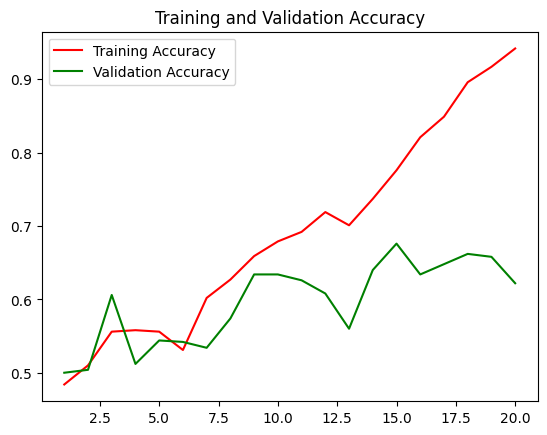

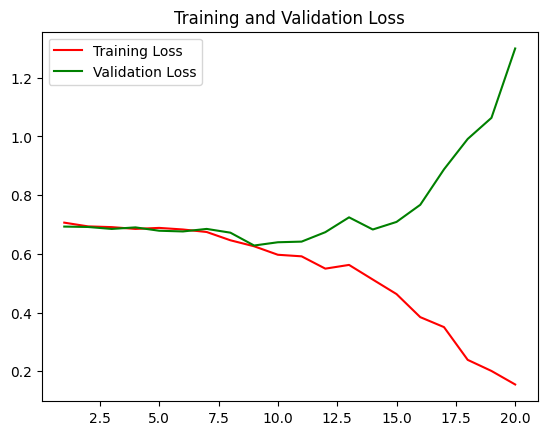

In [14]:
accuracy = Model_1.history["accuracy"]
val_accuracy = Model_1.history["val_accuracy"]

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color= "Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [15]:
#Evaluating the performance of Model_1
test_model = keras.models.load_model("model1.keras")
Model1_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

16/16 [==============================] - 3s 194ms/step - loss: 0.6921 - accuracy: 0.6040
Loss: 0.692
Accuracy: 0.604


*Using Measures to Avoid Overfitting*
*Data Augmentation*

In [16]:
# To deprecate warnings that are making the output look clumsy
import logging
logging.getLogger('tensorflow').disabled = True

In [17]:
#Using few of the techniques such as random flip, random zoom, random rotation so as to create augmented versions of the image
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

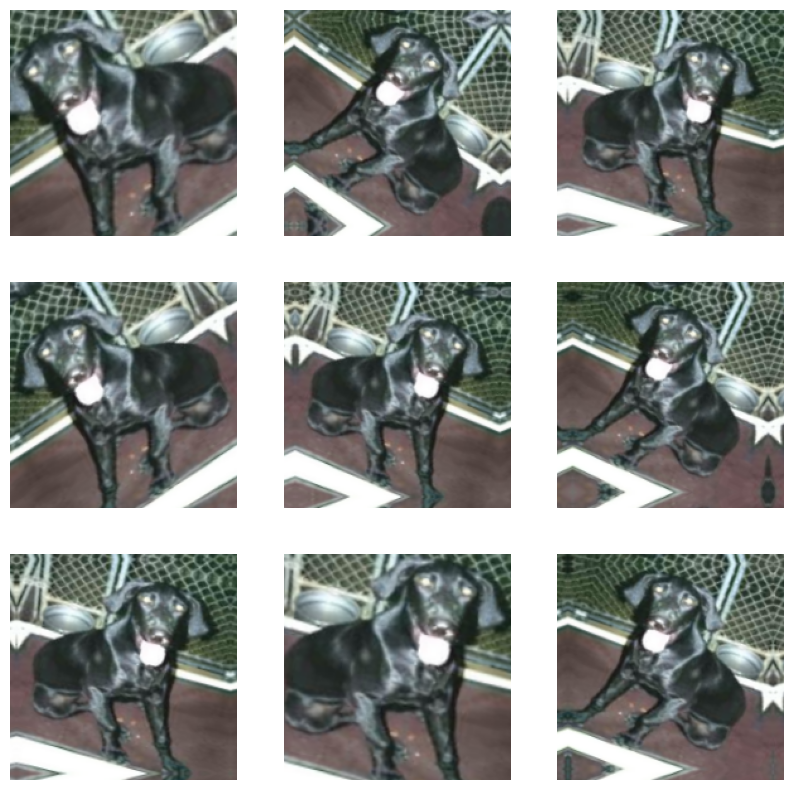

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

*Model_Maxpooling_filters32_512_layer5_Augumentedimage_droput0.5*

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
# Compiling the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Saving the results of the model
callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Fitting/Running the Model
Model_2 = model.fit(
          train_dataset,
          epochs= 30,
          validation_data= validation_dataset,
          callbacks= callbacks)

Epoch 1/30
32/32 [==============================] - 29s 856ms/step - loss: 0.6995 - accuracy: 0.4660 - val_loss: 0.6919 - val_accuracy: 0.5320
Epoch 2/30
32/32 [==============================] - 29s 894ms/step - loss: 0.6933 - accuracy: 0.4970 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 27s 847ms/step - loss: 0.6889 - accuracy: 0.5420 - val_loss: 0.6765 - val_accuracy: 0.5960
Epoch 4/30
32/32 [==============================] - 29s 900ms/step - loss: 0.6893 - accuracy: 0.5470 - val_loss: 0.6860 - val_accuracy: 0.5840
Epoch 5/30
32/32 [==============================] - 29s 902ms/step - loss: 0.6756 - accuracy: 0.5840 - val_loss: 0.6655 - val_accuracy: 0.5740
Epoch 6/30
32/32 [==============================] - 27s 838ms/step - loss: 0.6617 - accuracy: 0.6040 - val_loss: 0.6667 - val_accuracy: 0.6040
Epoch 7/30
32/32 [==============================] - 29s 914ms/step - loss: 0.6498 - accuracy: 0.6150 - val_loss: 0.6355 - val_accuracy: 0.6160

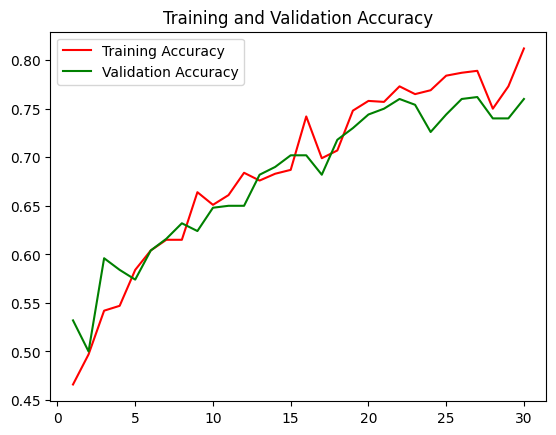

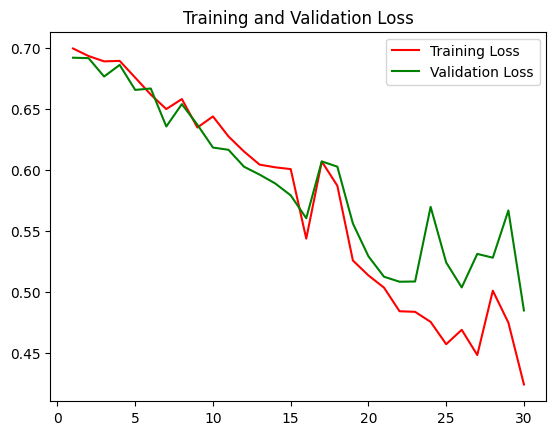

In [22]:
accuracy = Model_2.history["accuracy"]
val_accuracy = Model_2.history["val_accuracy"]

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [23]:
test_model = keras.models.load_model("model2.keras")
Model2_Results = test_model.evaluate(test_dataset)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

16/16 [==============================] - 4s 235ms/step - loss: 0.5869 - accuracy: 0.7380
Loss: 0.587
Accuracy: 0.738


*Model_MaxPooling_filter32_1024_Layers6_with_Augmentedimage_Dropout0.6*

In [24]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [26]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_4 = model.fit(
          train_dataset,
          epochs= 30,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/30
32/32 [==============================] - 40s 1s/step - loss: 0.6975 - accuracy: 0.5040 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 40s 1s/step - loss: 0.6973 - accuracy: 0.4920 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 41s 1s/step - loss: 0.6941 - accuracy: 0.4910 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 39s 1s/step - loss: 0.6942 - accuracy: 0.4860 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 38s 1s/step - loss: 0.6938 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/30
32/32 [==============================] - 38s 1s/step - loss: 0.6935 - accuracy: 0.4940 - val_loss: 0.6929 - val_accuracy: 0.5620
Epoch 7/30
32/32 [==============================] - 37s 1s/step - loss: 0.6929 - accuracy: 0.5220 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/30
32/32 [==

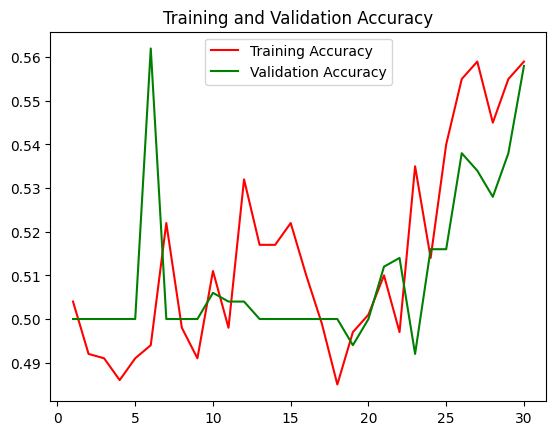

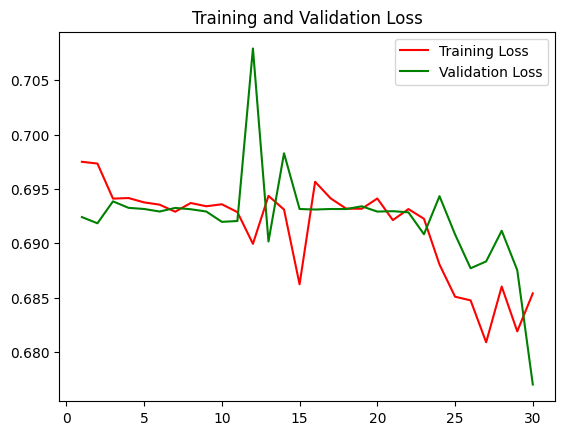

In [27]:
accuracy = Model_4.history["accuracy"]
val_accuracy = Model_4.history["val_accuracy"]

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green",label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [28]:
best_model = keras.models.load_model("model4.keras")
Model4_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

16/16 [==============================] - 3s 186ms/step - loss: 0.6804 - accuracy: 0.5600
Loss: 0.680
Accuracy: 0.560


In [30]:
import numpy as np
import pandas as pd
from IPython.display import display

Models = ("Model_MaxPooling_filter32_512_Layers5","Model_MaxPooling_filter32_512_Layers5_with_Augmentedimage_Dropout0.5","Model_MaxPooling_filter32_1024_Layers6_with_Augmentedimage_Dropout0.6")
Loss = (Model1_Results[0],Model2_Results[0],Model4_Results[0])
Accuracy = (Model1_Results[1],Model2_Results[1],Model4_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the row with the highest accuracy
max_accuracy_index = df['Accuracy (%)'].idxmax()

# Highlight the row with the highest accuracy
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlight function
df_styled = df.style.apply(highlight_max, subset=['Accuracy (%)'])

# Display the styled DataFrame
display(df_styled)

,Model,Loss (%),Accuracy (%)
0,Model_MaxPooling_filter32_512_Layers5,0.692103,0.604000
1,Model_MaxPooling_filter32_512_Layers5_with_Augmentedimage_Dropout0.5,0.586901,0.738000
2,Model_MaxPooling_filter32_1024_Layers6_with_Augmentedimage_Dropout0.6,0.680398,0.560000


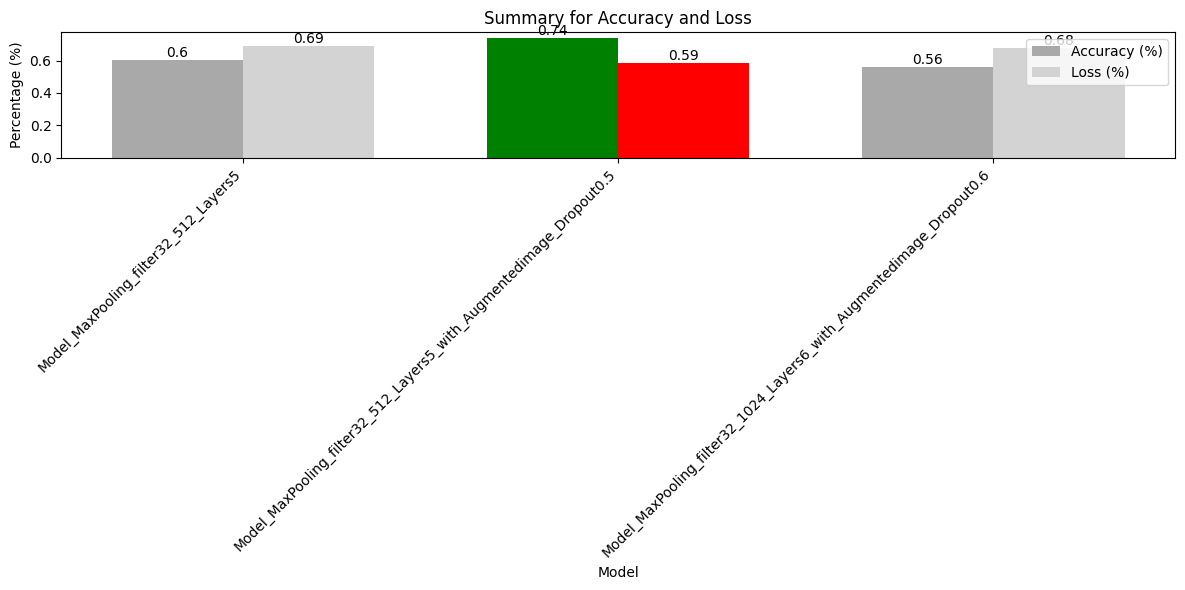

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_M11, results_M12, etc. are defined elsewhere in your code
Models = ("Model_MaxPooling_filter32_512_Layers5","Model_MaxPooling_filter32_512_Layers5_with_Augmentedimage_Dropout0.5","Model_MaxPooling_filter32_1024_Layers6_with_Augmentedimage_Dropout0.6")
Loss = (Model1_Results[0],Model2_Results[0],Model4_Results[0])
Accuracy = (Model1_Results[1],Model2_Results[1],Model4_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the indices of the highest accuracy and lowest loss
max_accuracy_index = df['Accuracy (%)'].idxmax()
min_loss_index = df['Loss (%)'].idxmin()

# Create a grouped bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set colors: dark gray for accuracy, light gray for loss, red for lowest loss, green for highest accuracy
colors_accuracy = ['darkgray'] * len(df)
colors_loss = ['lightgray'] * len(df)
colors_accuracy[max_accuracy_index] = 'green'
colors_loss[min_loss_index] = 'red'

# Plot the bars
bar_width = 0.35
index = np.arange(len(df))

bars1 = ax.bar(index, df['Accuracy (%)'], bar_width, label='Accuracy (%)', color=colors_accuracy)
bars2 = ax.bar(index + bar_width, df['Loss (%)'], bar_width, label='Loss (%)', color=colors_loss)

# Annotate the bars with the accuracy and loss values
for bar, accuracy in zip(bars1, df['Accuracy (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), va='bottom', ha='center')  # va: vertical alignment

for bar, loss in zip(bars2, df['Loss (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(loss, 2), va='bottom', ha='center')  # va: vertical alignment

# Add labels and title
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Percentage (%)")
plt.xlabel("Model")
plt.xticks(index + bar_width / 2, df['Model'], rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# ***2.Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch).What performance did you achieve?***

In [32]:
import os, shutil, pathlib
#shutil.rmtree("cats_vs_dogs_small/train/cat")

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok = True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [33]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [34]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [35]:
data_augmentation_1 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

*Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_sample2000*

In [36]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [37]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [38]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_5 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
63/63 [==============================] - 52s 797ms/step - loss: 0.6943 - accuracy: 0.5045 - val_loss: 0.6927 - val_accuracy: 0.5120
Epoch 2/50
63/63 [==============================] - 49s 786ms/step - loss: 0.6927 - accuracy: 0.5220 - val_loss: 0.6847 - val_accuracy: 0.5360
Epoch 3/50
63/63 [==============================] - 50s 799ms/step - loss: 0.6886 - accuracy: 0.5390 - val_loss: 0.6666 - val_accuracy: 0.5620
Epoch 4/50
63/63 [==============================] - 55s 873ms/step - loss: 0.6938 - accuracy: 0.4970 - val_loss: 0.6925 - val_accuracy: 0.4980
Epoch 5/50
63/63 [==============================] - 53s 840ms/step - loss: 0.6888 - accuracy: 0.5235 - val_loss: 0.6723 - val_accuracy: 0.5940
Epoch 6/50
63/63 [==============================] - 50s 790ms/step - loss: 0.6868 - accuracy: 0.5625 - val_loss: 0.6826 - val_accuracy: 0.5600
Epoch 7/50
63/63 [==============================] - 56s 888ms/step - loss: 0.6777 - accuracy: 0.5845 - val_loss: 0.6590 - val_accuracy: 0.6320

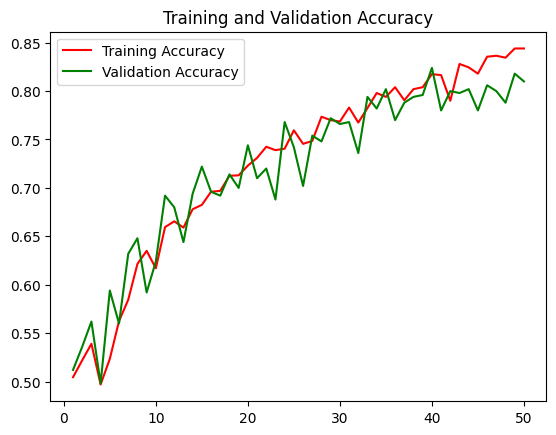

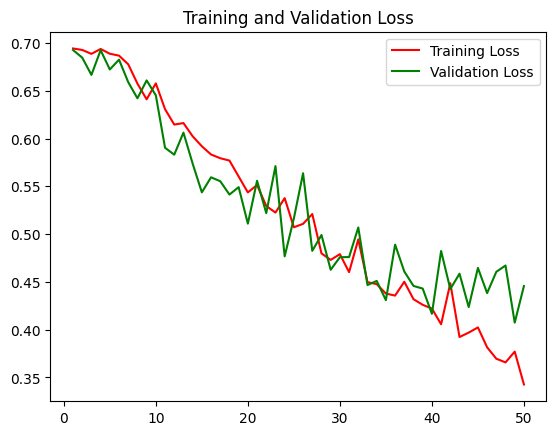

In [39]:
accuracy = Model_5.history["accuracy"]
val_accuracy = Model_5.history["val_accuracy"]

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [40]:
best_model = keras.models.load_model("model5.keras")
Model5_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

16/16 [==============================] - 3s 196ms/step - loss: 0.4375 - accuracy: 0.8160
Loss: 0.437
Accuracy: 0.816


*Model_Padding"Same"_filters32_256_Layers5_AugmentedImages_droput0.5_Sample2000*

In [41]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_1(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [42]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 90, 90, 32)        896       
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 conv2d_24 (Conv2D)          (None, 12, 12, 256)       2951

In [43]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model6.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_6 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
63/63 [==============================] - 18s 256ms/step - loss: 0.6962 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 16s 249ms/step - loss: 0.6952 - accuracy: 0.5125 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 15s 242ms/step - loss: 0.6933 - accuracy: 0.5105 - val_loss: 0.6903 - val_accuracy: 0.5580
Epoch 4/50
63/63 [==============================] - 16s 253ms/step - loss: 0.6912 - accuracy: 0.5330 - val_loss: 0.6861 - val_accuracy: 0.5480
Epoch 5/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6905 - accuracy: 0.5375 - val_loss: 0.6897 - val_accuracy: 0.5260
Epoch 6/50
63/63 [==============================] - 16s 249ms/step - loss: 0.6937 - accuracy: 0.5350 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 7/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6932 - accuracy: 0.5140 - val_loss: 0.6890 - val_accuracy: 0.5520

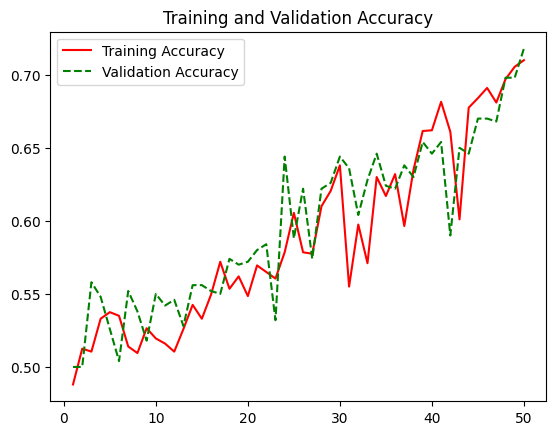

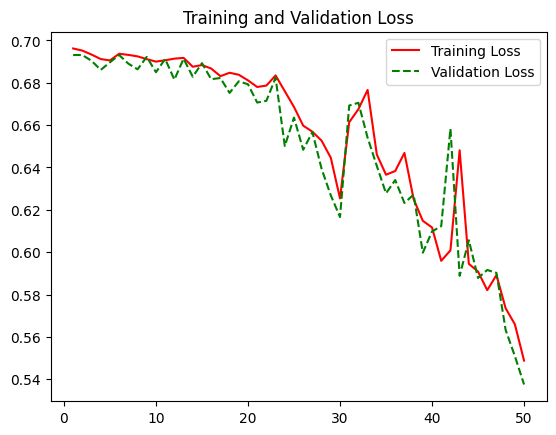

In [44]:
accuracy = Model_6.history["accuracy"]
val_accuracy = Model_6.history["val_accuracy"]

loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [45]:
best_model = keras.models.load_model("model6.keras")
Model6_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model6_Results[0]:.3f}')
print(f'Accuracy: {Model6_Results[1]:.3f}')

16/16 [==============================] - 1s 59ms/step - loss: 0.6146 - accuracy: 0.6900
Loss: 0.615
Accuracy: 0.690


In [46]:
import numpy as np
import pandas as pd
from IPython.display import display

Models = ("Model_PaddingSame_filters32_256_Layers5_AugmentedImages_droput0.5_Sample2000","Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_sample2000")
Loss = (Model5_Results[0],Model6_Results[0])
Accuracy = (Model5_Results[1],Model6_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the row with the highest accuracy
max_accuracy_index = df['Accuracy (%)'].idxmax()

# Highlight the row with the highest accuracy
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlight function
df_styled = df.style.apply(highlight_max, subset=['Accuracy (%)'])

# Display the styled DataFrame
display(df_styled)

,Model,Loss (%),Accuracy (%)
0,Model_PaddingSame_filters32_256_Layers5_AugmentedImages_droput0.5_Sample2000,0.437496,0.816000
1,Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_sample2000,0.614555,0.690000


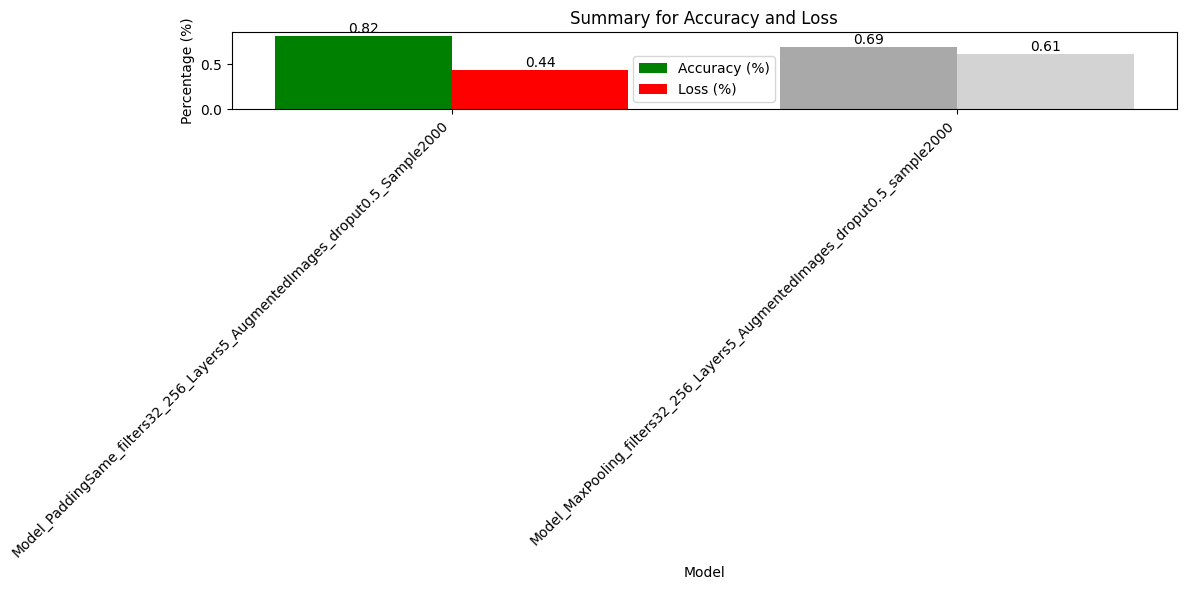

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_M11, results_M12, etc. are defined elsewhere in your code
Models = ("Model_PaddingSame_filters32_256_Layers5_AugmentedImages_droput0.5_Sample2000","Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_sample2000")
Loss = (Model5_Results[0],Model6_Results[0])
Accuracy = (Model5_Results[1],Model6_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the indices of the highest accuracy and lowest loss
max_accuracy_index = df['Accuracy (%)'].idxmax()
min_loss_index = df['Loss (%)'].idxmin()

# Create a grouped bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set colors: dark gray for accuracy, light gray for loss, red for lowest loss, green for highest accuracy
colors_accuracy = ['darkgray'] * len(df)
colors_loss = ['lightgray'] * len(df)
colors_accuracy[max_accuracy_index] = 'green'
colors_loss[min_loss_index] = 'red'

# Plot the bars
bar_width = 0.35
index = np.arange(len(df))

bars1 = ax.bar(index, df['Accuracy (%)'], bar_width, label='Accuracy (%)', color=colors_accuracy)
bars2 = ax.bar(index + bar_width, df['Loss (%)'], bar_width, label='Loss (%)', color=colors_loss)

# Annotate the bars with the accuracy and loss values
for bar, accuracy in zip(bars1, df['Accuracy (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), va='bottom', ha='center')  # va: vertical alignment

for bar, loss in zip(bars2, df['Loss (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(loss, 2), va='bottom', ha='center')  # va: vertical alignment

# Add labels and title
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Percentage (%)")
plt.xlabel("Model")
plt.xticks(index + bar_width / 2, df['Model'], rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# ***3.Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results***

***As we saw in above graph that with the increase in training sample size the Accuracy is also increasing hence will <b>increase the sample size to 3000 and 5000 for better performance***

In [48]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [49]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [50]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [51]:
data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)


*Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample3000*

In [52]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [53]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [54]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model7.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_7 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
94/94 [==============================] - 73s 763ms/step - loss: 0.6941 - accuracy: 0.5097 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/50
94/94 [==============================] - 71s 751ms/step - loss: 0.6887 - accuracy: 0.5517 - val_loss: 0.6638 - val_accuracy: 0.5860
Epoch 3/50
94/94 [==============================] - 70s 739ms/step - loss: 0.6637 - accuracy: 0.6010 - val_loss: 0.7600 - val_accuracy: 0.5720
Epoch 4/50
94/94 [==============================] - 69s 735ms/step - loss: 0.6738 - accuracy: 0.5840 - val_loss: 0.6395 - val_accuracy: 0.6340
Epoch 5/50
94/94 [==============================] - 70s 740ms/step - loss: 0.6553 - accuracy: 0.6147 - val_loss: 0.7165 - val_accuracy: 0.5860
Epoch 6/50
94/94 [==============================] - 70s 742ms/step - loss: 0.6406 - accuracy: 0.6433 - val_loss: 0.7095 - val_accuracy: 0.5540
Epoch 7/50
94/94 [==============================] - 74s 782ms/step - loss: 0.6353 - accuracy: 0.6517 - val_loss: 0.6468 - val_accuracy: 0.6460

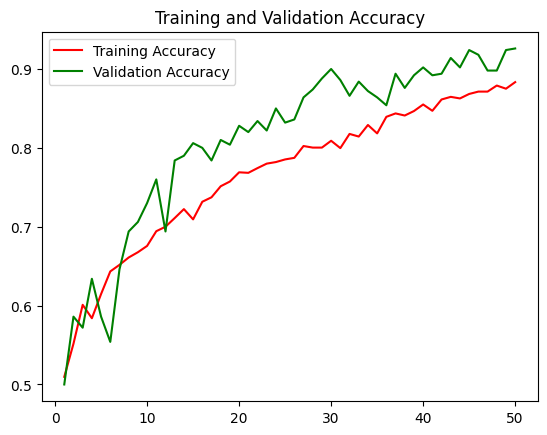

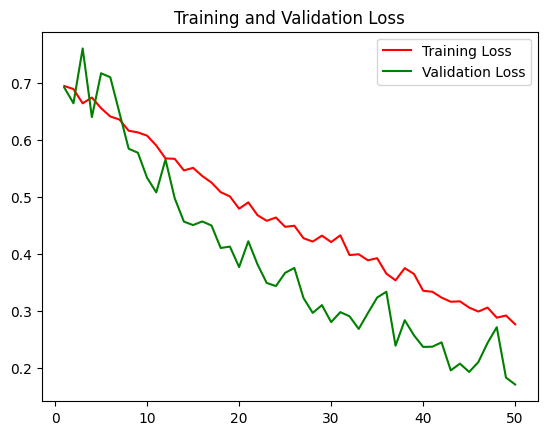

In [56]:
accuracy = Model_7.history["accuracy"]
val_accuracy = Model_7.history["val_accuracy"]

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [57]:
best_model = keras.models.load_model("model7.keras")
Model7_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model7_Results[0]:.3f}')
print(f'Accuracy: {Model7_Results[1]:.3f}')

16/16 [==============================] - 3s 161ms/step - loss: 0.4178 - accuracy: 0.8320
Loss: 0.418
Accuracy: 0.832


In [58]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

*Model_MaxPooling_Stride2_Padding_filters32_512_Layers5_AugmentedImages_droput0.5_Sample3000*

In [59]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_2(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,strides=2, padding="same")(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [60]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [61]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model9.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_9 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
94/94 [==============================] - 79s 822ms/step - loss: 0.6994 - accuracy: 0.4983 - val_loss: 0.6929 - val_accuracy: 0.5020
Epoch 2/50
94/94 [==============================] - 75s 802ms/step - loss: 0.6934 - accuracy: 0.5040 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 3/50
94/94 [==============================] - 75s 802ms/step - loss: 0.6854 - accuracy: 0.5450 - val_loss: 0.6787 - val_accuracy: 0.5500
Epoch 4/50
94/94 [==============================] - 75s 795ms/step - loss: 0.6910 - accuracy: 0.5387 - val_loss: 0.6909 - val_accuracy: 0.5480
Epoch 5/50
94/94 [==============================] - 75s 793ms/step - loss: 0.6830 - accuracy: 0.5870 - val_loss: 0.6799 - val_accuracy: 0.5960
Epoch 6/50
94/94 [==============================] - 76s 803ms/step - loss: 0.6549 - accuracy: 0.6243 - val_loss: 0.6283 - val_accuracy: 0.6260
Epoch 7/50
94/94 [==============================] - 74s 788ms/step - loss: 0.6502 - accuracy: 0.6297 - val_loss: 0.6387 - val_accuracy: 0.6400

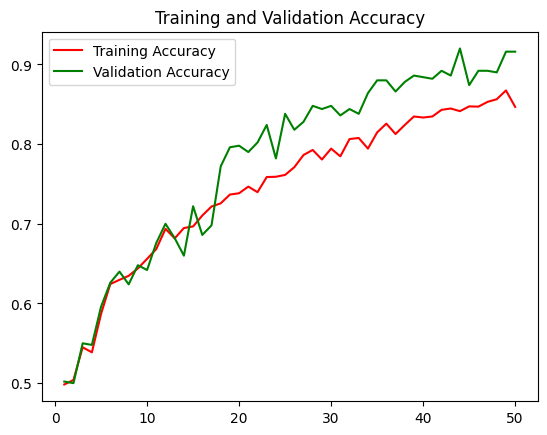

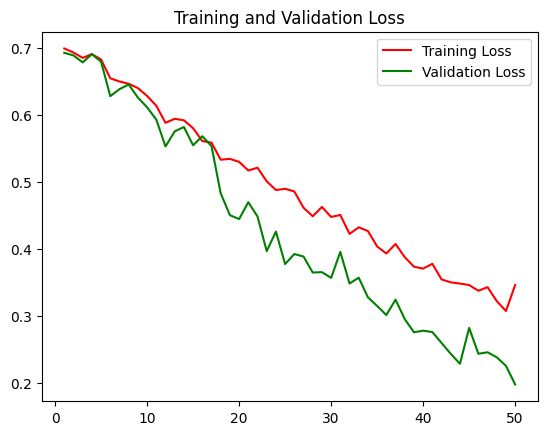

In [62]:
accuracy = Model_9.history["accuracy"]
val_accuracy = Model_9.history["val_accuracy"]

loss = Model_9.history["loss"]
val_loss = Model_9.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green",label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [63]:
best_model = keras.models.load_model("model9.keras")
Model9_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model9_Results[0]:.3f}')
print(f'Accuracy: {Model9_Results[1]:.3f}')

16/16 [==============================] - 3s 198ms/step - loss: 0.3903 - accuracy: 0.8320
Loss: 0.390
Accuracy: 0.832


In [64]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2500)
make_subset("validation", start_index=1000, end_index=1250)
make_subset("test", start_index=1500, end_index=1750)

In [65]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [66]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [67]:
data_augmentation_3 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25)
    ]
)

*Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample5000*

In [68]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_3(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 87, 87, 64)        18496     
                                                          

In [69]:
# Compiling the Model
model.compile(loss= "binary_crossentropy",
              optimizer= "adam",
              metrics= ['accuracy'])


# Monitoring the best validation loss using Callbacks
callbacks = ModelCheckpoint(
            filepath = "model10.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Model_10 = model.fit(
          train_dataset,
          epochs= 50,
          validation_data= validation_dataset,
          callbacks= callbacks
          )

Epoch 1/50
157/157 [==============================] - 128s 805ms/step - loss: 0.6918 - accuracy: 0.5240 - val_loss: 0.6798 - val_accuracy: 0.5740
Epoch 2/50
157/157 [==============================] - 123s 781ms/step - loss: 0.6722 - accuracy: 0.5962 - val_loss: 0.6889 - val_accuracy: 0.5260
Epoch 3/50
157/157 [==============================] - 121s 772ms/step - loss: 0.6582 - accuracy: 0.6106 - val_loss: 0.6463 - val_accuracy: 0.6360
Epoch 4/50
157/157 [==============================] - 117s 745ms/step - loss: 0.6489 - accuracy: 0.6300 - val_loss: 0.6290 - val_accuracy: 0.6960
Epoch 5/50
157/157 [==============================] - 117s 745ms/step - loss: 0.6515 - accuracy: 0.6146 - val_loss: 0.5821 - val_accuracy: 0.7280
Epoch 6/50
157/157 [==============================] - 116s 736ms/step - loss: 0.6102 - accuracy: 0.6640 - val_loss: 0.5280 - val_accuracy: 0.7460
Epoch 7/50
157/157 [==============================] - 117s 745ms/step - loss: 0.5859 - accuracy: 0.6910 - val_loss: 0.5127 -

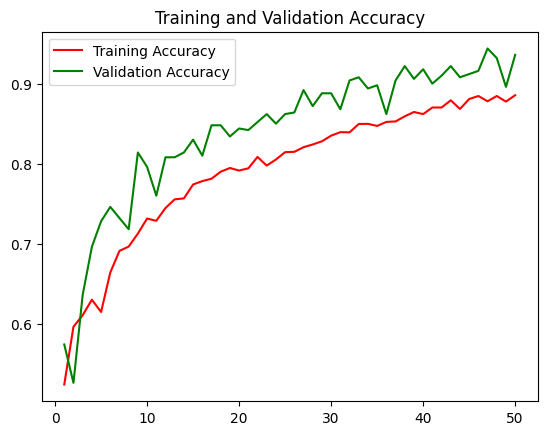

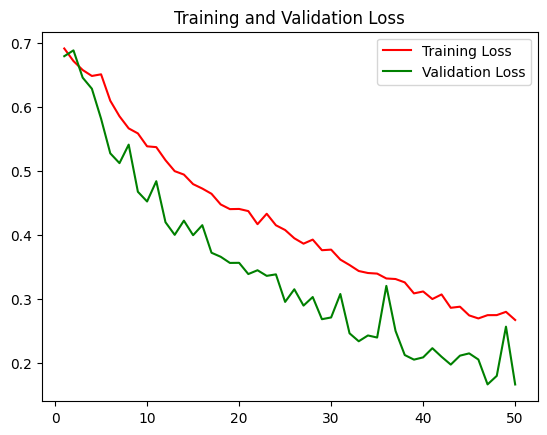

In [70]:
accuracy = Model_10.history["accuracy"]
val_accuracy = Model_10.history["val_accuracy"]

loss = Model_10.history["loss"]
val_loss = Model_10.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, color="Red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [71]:
best_model = keras.models.load_model("model10.keras")
Model10_Results = best_model.evaluate(test_dataset)
print(f'Loss: {Model10_Results[0]:.3f}')
print(f'Accuracy: {Model10_Results[1]:.3f}')

16/16 [==============================] - 3s 166ms/step - loss: 0.2051 - accuracy: 0.9140
Loss: 0.205
Accuracy: 0.914


In [72]:
import numpy as np
import pandas as pd
from IPython.display import display

Models = ("Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample3000","Model_MaxPooling_Stride2_Padding_filters32_512_Layers5_AugmentedImages_droput0.5_Sample3000","Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample5000")
Loss = (Model7_Results[0], Model9_Results[0],Model10_Results[0])
Accuracy = (Model7_Results[1], Model9_Results[1],Model10_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the row with the highest accuracy
max_accuracy_index = df['Accuracy (%)'].idxmax()

# Highlight the row with the highest accuracy
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlight function
df_styled = df.style.apply(highlight_max, subset=['Accuracy (%)'])

# Display the styled DataFrame
display(df_styled)

,Model,Loss (%),Accuracy (%)
0,Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample3000,0.417832,0.832000
1,Model_MaxPooling_Stride2_Padding_filters32_512_Layers5_AugmentedImages_droput0.5_Sample3000,0.390275,0.832000
2,Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample5000,0.205114,0.914000


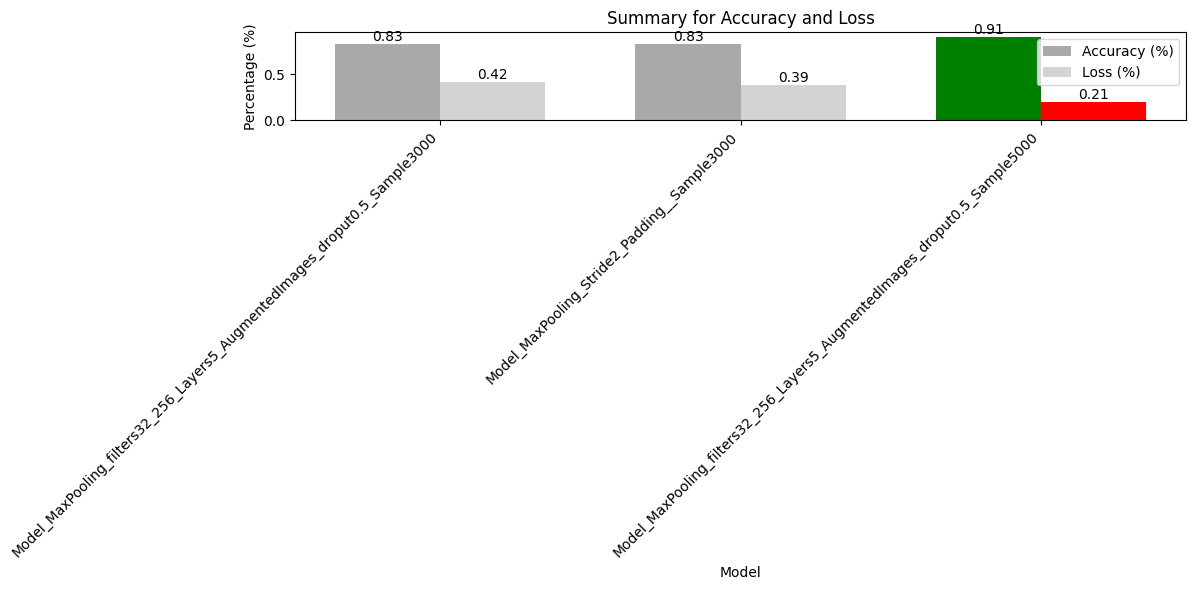

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_M11, results_M12, etc. are defined elsewhere in your code
Models = ("Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample3000","Model_MaxPooling_Stride2_Padding__Sample3000","Model_MaxPooling_filters32_256_Layers5_AugmentedImages_droput0.5_Sample5000")
Loss = (Model7_Results[0], Model9_Results[0],Model10_Results[0])
Accuracy = (Model7_Results[1], Model9_Results[1],Model10_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the indices of the highest accuracy and lowest loss
max_accuracy_index = df['Accuracy (%)'].idxmax()
min_loss_index = df['Loss (%)'].idxmin()

# Create a grouped bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set colors: dark gray for accuracy, light gray for loss, red for lowest loss, green for highest accuracy
colors_accuracy = ['darkgray'] * len(df)
colors_loss = ['lightgray'] * len(df)
colors_accuracy[max_accuracy_index] = 'green'
colors_loss[min_loss_index] = 'red'

# Plot the bars
bar_width = 0.35
index = np.arange(len(df))

bars1 = ax.bar(index, df['Accuracy (%)'], bar_width, label='Accuracy (%)', color=colors_accuracy)
bars2 = ax.bar(index + bar_width, df['Loss (%)'], bar_width, label='Loss (%)', color=colors_loss)

# Annotate the bars with the accuracy and loss values
for bar, accuracy in zip(bars1, df['Accuracy (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), va='bottom', ha='center')  # va: vertical alignment

for bar, loss in zip(bars2, df['Loss (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(loss, 2), va='bottom', ha='center')  # va: vertical alignment

# Add labels and title
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Percentage (%)")
plt.xlabel("Model")
plt.xticks(index + bar_width / 2, df['Model'], rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# ***4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance***

*Use Pretrained Model VGG16*

In [75]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [76]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [77]:
#extracting VGG 16 features and Labels
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


In [78]:
train_features.shape

(5000, 5, 5, 512)

*Model_VGG16_DenseLayer256Nodes_Droput0.5_optimizer_rmsprop*

In [79]:
# Defining and Training the densely connected classifier
# The last dense stacked layer and the classifier
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath="vgg_model1.keras",
            save_best_only=True,
            monitor="val_loss")


# Model Fit
VGG_Model_1 = model.fit(
              train_features, train_labels,
              epochs= 30,
              validation_data= (val_features, val_labels),
              callbacks= callbacks)

Epoch 1/30
157/157 [==============================] - 2s 11ms/step - loss: 9.1702 - accuracy: 0.9476 - val_loss: 2.5383 - val_accuracy: 0.9880
Epoch 2/30
157/157 [==============================] - 2s 11ms/step - loss: 2.9815 - accuracy: 0.9824 - val_loss: 0.0198 - val_accuracy: 0.9980
Epoch 3/30
157/157 [==============================] - 2s 11ms/step - loss: 1.9774 - accuracy: 0.9864 - val_loss: 0.5143 - val_accuracy: 0.9920
Epoch 4/30
157/157 [==============================] - 2s 11ms/step - loss: 1.2542 - accuracy: 0.9888 - val_loss: 0.0409 - val_accuracy: 0.9980
Epoch 5/30
157/157 [==============================] - 2s 11ms/step - loss: 1.5312 - accuracy: 0.9904 - val_loss: 1.2659 - val_accuracy: 0.9900
Epoch 6/30
157/157 [==============================] - 2s 10ms/step - loss: 0.7276 - accuracy: 0.9944 - val_loss: 0.3292 - val_accuracy: 0.9980
Epoch 7/30
157/157 [==============================] - 2s 10ms/step - loss: 0.4485 - accuracy: 0.9960 - val_loss: 0.0000e+00 - val_accuracy: 1.

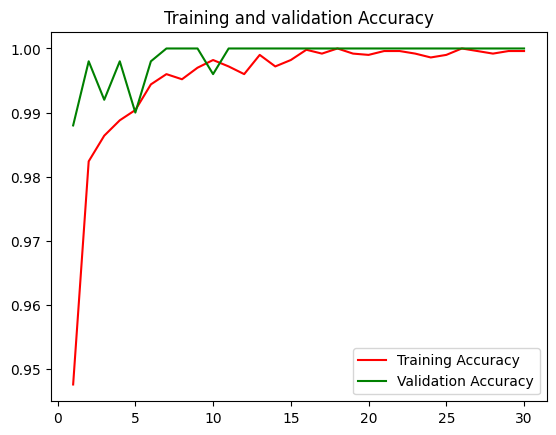

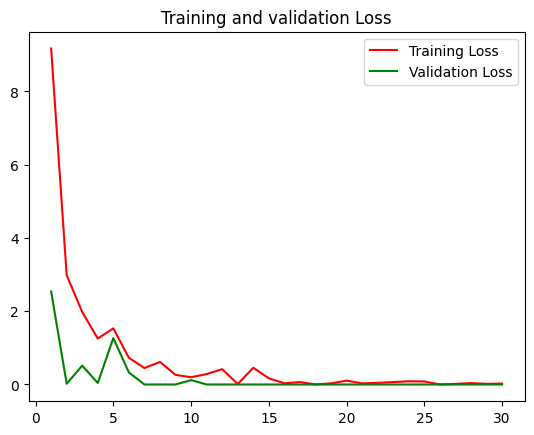

In [80]:
acc = VGG_Model_1.history["accuracy"]
val_acc = VGG_Model_1.history["val_accuracy"]

loss = VGG_Model_1.history["loss"]
val_loss = VGG_Model_1.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="Red", label="Training Accuracy")
plt.plot(epochs, val_acc, color="Green", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [81]:
best_model = keras.models.load_model("vgg_model1.keras")
VGG_Model_1_Results = best_model.evaluate(test_features,test_labels)
print(f'Loss: {VGG_Model_1_Results[0]:.3f}')
print(f'Accuracy: {VGG_Model_1_Results[1]:.3f}')

16/16 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.9960
Loss: 0.069
Accuracy: 0.996


In [82]:
# Before Freezing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [83]:
# After Freezing
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [84]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

*Model_VGG16_DenseLayer256Nodes_Droput_0.5_optimizerrmsprop_AugmentedImages*

In [85]:
# Data Augmentation -Adding a data augmentation stage to provide augmented training samples and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


In [ ]:
# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath= "vgg_model2.keras",
            save_best_only= True,
            monitor= "val_loss")

# Model Fit
VGG_Model_2 = model.fit(
              train_dataset,
              epochs= 30,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/30
 21/157 [===>..........................] - ETA: 5:46 - loss: 36.3417 - accuracy: 0.8646

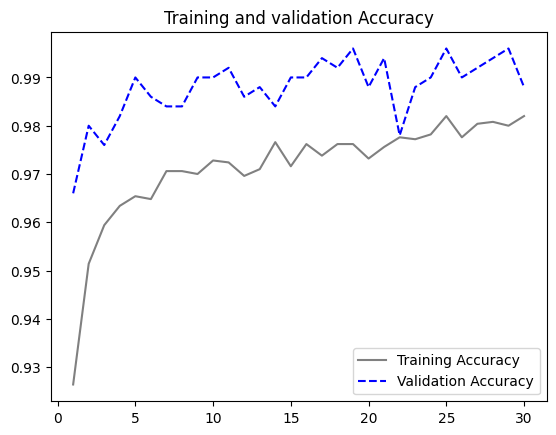

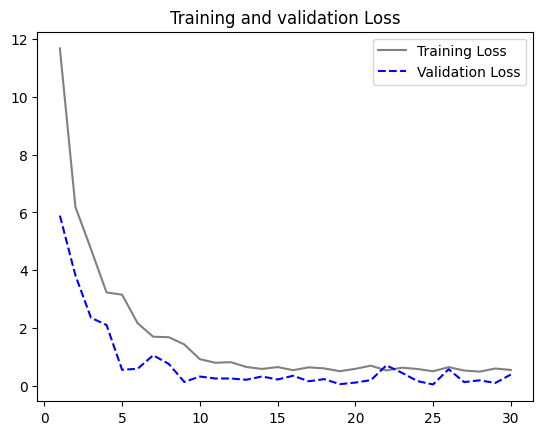

In [ ]:
acc = VGG_Model_2.history["accuracy"]
val_acc = VGG_Model_2.history["val_accuracy"]

loss = VGG_Model_2.history["loss"]
val_loss = VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="Red", label="Training Accuracy")
plt.plot(epochs, val_acc, color="Green", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("vgg_model2.keras")
VGG_Model_2_Results= best_model.evaluate(test_dataset)
print(f'Loss: {VGG_Model_2_Results[0]:.3f}')
print(f'Accuracy: {VGG_Model_2_Results[1]:.3f}')

16/16 [==============================] - 1s 31ms/step - loss: 0.0260 - accuracy: 0.9980
Loss: 0.026
Accuracy: 0.998


*Model_VGG16_DenseLayer256Nodes_Droput_0.5_optimizerrmsprop_AugmentedImages_finetune*

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


callbacks = ModelCheckpoint(
            filepath="fine_tuning_vgg_model2.keras",
            save_best_only=True,
            monitor="val_loss")


FineTuned_VGG_Model_2 = model.fit(
                        train_dataset,
                        epochs=30,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 9s 44ms/step - loss: 0.5814 - accuracy: 0.9812 - val_loss: 0.1324 - val_accuracy: 0.9920
Epoch 2/30
157/157 [==============================] - 7s 41ms/step - loss: 0.3211 - accuracy: 0.9838 - val_loss: 0.2911 - val_accuracy: 0.9900
Epoch 3/30
157/157 [==============================] - 7s 41ms/step - loss: 0.4245 - accuracy: 0.9828 - val_loss: 0.1409 - val_accuracy: 0.9960
Epoch 4/30
157/157 [==============================] - 7s 41ms/step - loss: 0.2823 - accuracy: 0.9856 - val_loss: 0.1580 - val_accuracy: 0.9960
Epoch 5/30
157/157 [==============================] - 7s 42ms/step - loss: 0.2966 - accuracy: 0.9868 - val_loss: 0.0682 - val_accuracy: 0.9980
Epoch 6/30
157/157 [==============================] - 7s 41ms/step - loss: 0.2301 - accuracy: 0.9866 - val_loss: 0.0912 - val_accuracy: 0.9960
Epoch 7/30
157/157 [==============================] - 7s 41ms/step - loss: 0.1625 - accuracy: 0.9888 - val_loss: 0.0850 - val_accuracy: 0.9980

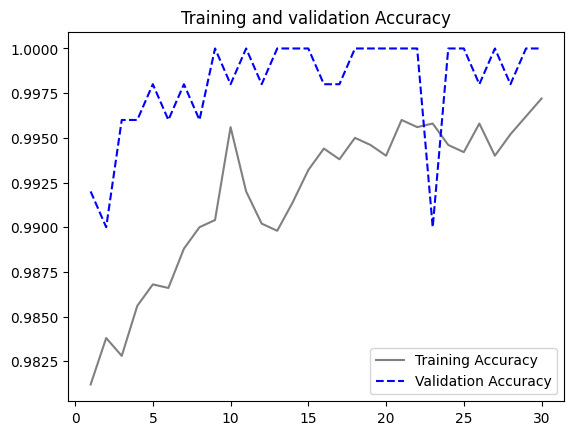

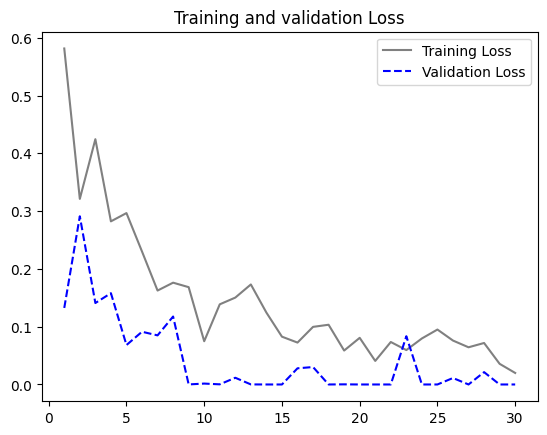

In [ ]:
acc = FineTuned_VGG_Model_2.history["accuracy"]
val_acc = FineTuned_VGG_Model_2.history["val_accuracy"]

loss = FineTuned_VGG_Model_2.history["loss"]
val_loss = FineTuned_VGG_Model_2.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="Red", label="Training Accuracy")
plt.plot(epochs, val_acc, color="Green", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_tuning_vgg_model2.keras")
FineTuned_VGG_Model_2_Results = best_model.evaluate(test_dataset)
print(f"Loss: {FineTuned_VGG_Model_2_Results[0]:.3f}")
print(f"Accuracy: {FineTuned_VGG_Model_2_Results[1]:.3f}")

16/16 [==============================] - 1s 31ms/step - loss: 4.7333e-08 - accuracy: 1.0000
Loss: 0.000
Accuracy: 1.000


*Model_VGG16_Sample5000*

In [ ]:
conv_base= keras.applications.vgg16.VGG16(
           weights="imagenet",
           include_top=False)

conv_base.trainable = False


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [ ]:
# Data Augmentation
data_augmentation_4 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.25),
    ]
)

# Adding the Classifier and Dense Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_4(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

# Compiling the Model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Using CallBacks to monitor the best val_loss
callbacks = ModelCheckpoint(
            filepath= "vgg_model3.keras",
            save_best_only= True,
            monitor= "val_loss")

# Model Fit
VGG_Model_3 = model.fit(
              train_dataset,
              epochs= 50,
              validation_data=validation_dataset,
              callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 8s 41ms/step - loss: 10.5988 - accuracy: 0.9154 - val_loss: 1.8303 - val_accuracy: 0.9860
Epoch 2/50
157/157 [==============================] - 6s 40ms/step - loss: 6.1195 - accuracy: 0.9448 - val_loss: 0.8026 - val_accuracy: 0.9860
Epoch 3/50
157/157 [==============================] - 6s 38ms/step - loss: 4.1963 - accuracy: 0.9504 - val_loss: 1.0276 - val_accuracy: 0.9840
Epoch 4/50
157/157 [==============================] - 6s 40ms/step - loss: 2.2763 - accuracy: 0.9618 - val_loss: 0.1023 - val_accuracy: 0.9960
Epoch 5/50
157/157 [==============================] - 6s 38ms/step - loss: 1.9037 - accuracy: 0.9580 - val_loss: 0.2311 - val_accuracy: 0.9940
Epoch 6/50
157/157 [==============================] - 6s 40ms/step - loss: 0.9389 - accuracy: 0.9644 - val_loss: 0.0859 - val_accuracy: 0.9960
Epoch 7/50
157/157 [==============================] - 6s 38ms/step - loss: 0.6627 - accuracy: 0.9674 - val_loss: 0.1129 - val_accuracy: 0.996

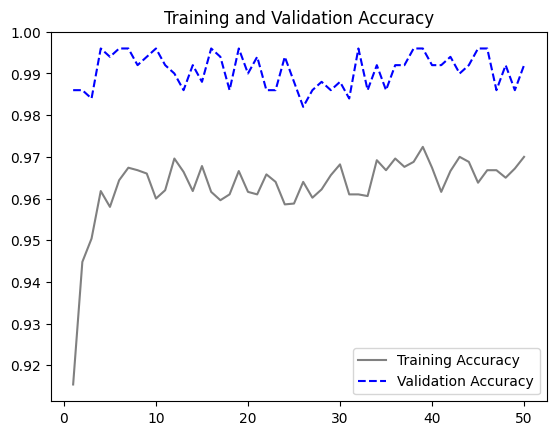

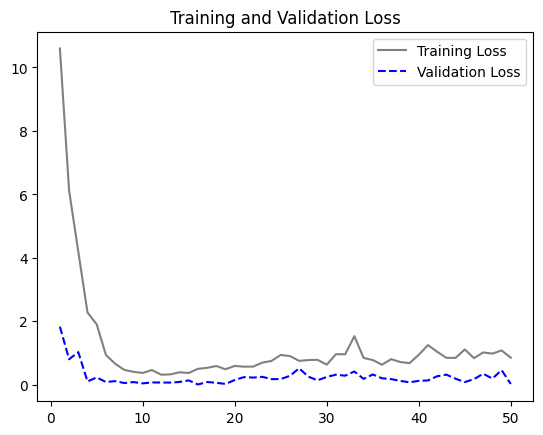

In [ ]:
acc = VGG_Model_3.history["accuracy"]
val_acc = VGG_Model_3.history["val_accuracy"]

loss = VGG_Model_3.history["loss"]
val_loss = VGG_Model_3.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="Red", label="Training Accuracy")
plt.plot(epochs, val_acc, color="Green", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("vgg_model3.keras")
VGG_Model_3_Results = best_model.evaluate(test_dataset)
print(f"Loss: {VGG_Model_3_Results[0]:.3f}")
print(f"Accuracy: {VGG_Model_3_Results[1]:.3f}")

16/16 [==============================] - 1s 32ms/step - loss: 0.1335 - accuracy: 0.9840
Loss: 0.134
Accuracy: 0.984


*Model_VGG16_Sample5000_finetune*

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])


callbacks = ModelCheckpoint(
            filepath="fine_tuning_vgg_model3.keras",
            save_best_only=True,
            monitor="val_loss")


FineTuned_VGG_Model_3 = model.fit(
                        train_dataset,
                        epochs=50,
                        validation_data=validation_dataset,
                        callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 10s 44ms/step - loss: 0.6214 - accuracy: 0.9730 - val_loss: 0.1435 - val_accuracy: 0.9880
Epoch 2/50
157/157 [==============================] - 7s 43ms/step - loss: 0.5057 - accuracy: 0.9704 - val_loss: 0.0525 - val_accuracy: 0.9920
Epoch 3/50
157/157 [==============================] - 7s 41ms/step - loss: 0.3409 - accuracy: 0.9768 - val_loss: 0.0897 - val_accuracy: 0.9960
Epoch 4/50
157/157 [==============================] - 7s 41ms/step - loss: 0.3513 - accuracy: 0.9760 - val_loss: 0.1144 - val_accuracy: 0.9960
Epoch 5/50
157/157 [==============================] - 7s 44ms/step - loss: 0.2530 - accuracy: 0.9808 - val_loss: 0.0221 - val_accuracy: 0.9980
Epoch 6/50
157/157 [==============================] - 7s 42ms/step - loss: 0.2061 - accuracy: 0.9836 - val_loss: 0.0499 - val_accuracy: 0.9960
Epoch 7/50
157/157 [==============================] - 7s 42ms/step - loss: 0.1904 - accuracy: 0.9840 - val_loss: 0.0526 - val_accuracy: 0.996

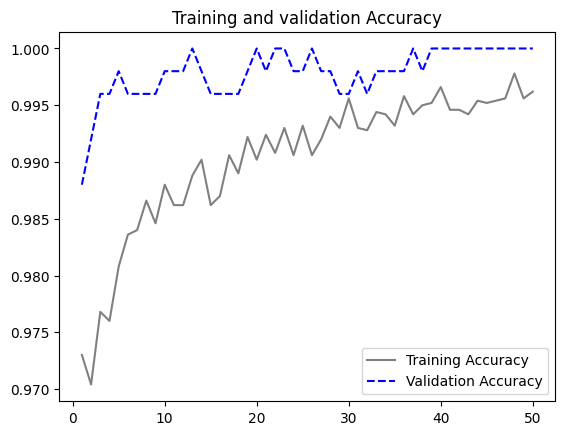

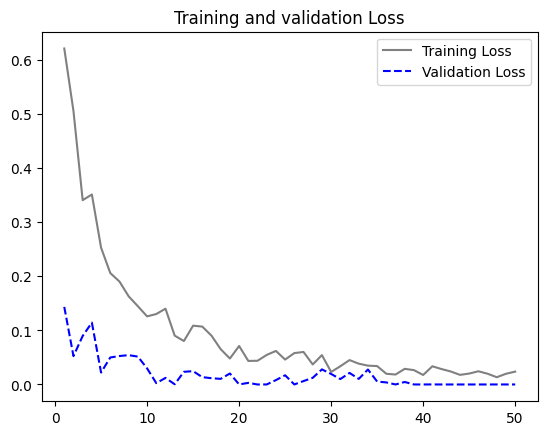

In [ ]:
acc = FineTuned_VGG_Model_3.history["accuracy"]
val_acc = FineTuned_VGG_Model_3.history["val_accuracy"]

loss = FineTuned_VGG_Model_3.history["loss"]
val_loss = FineTuned_VGG_Model_3.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color="Red", label="Training Accuracy")
plt.plot(epochs, val_acc, color="Green", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, color="Red", label="Training Loss")
plt.plot(epochs, val_loss, color="Green", linestyle="dashed", label="Validation Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model("fine_tuning_vgg_model3.keras")
FineTuned_VGG_Model_3_Results = best_model.evaluate(test_dataset)
print(f"Loss: {FineTuned_VGG_Model_3_Results[0]:.3f}")
print(f"Accuracy: {FineTuned_VGG_Model_3_Results[1]:.3f}")

16/16 [==============================] - 1s 32ms/step - loss: 1.5571e-08 - accuracy: 1.0000
Loss: 0.000
Accuracy: 1.000


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

Models = ("Model_VGG16_DenseLayer256Nodes_Droput0.5_optimizer_rmsprop","Model_VGG16_DenseLayer256Nodes_Droput_0.5_optimizerrmsprop_AugmentedImages",
          "Model_VGG16_DenseLayer256Nodes_Droput_0.5_optimizerrmsprop_AugmentedImages_finetune","Model_VGG16_Sample5000","Model_VGG16_Sample5000_finetune")
Loss = (VGG_Model_1_Results[0], VGG_Model_2_Results[0],FineTuned_VGG_Model_2_Results[0],FineTuned_VGG_Model_3_Results[0],VGG_Model_3_Results[0])
Accuracy = (VGG_Model_1_Results[1], VGG_Model_2_Results[1],FineTuned_VGG_Model_2_Results[1],FineTuned_VGG_Model_3_Results[1],VGG_Model_3_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the row with the highest accuracy
max_accuracy_index = df['Accuracy (%)'].idxmax()

# Highlight the row with the highest accuracy
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlight function
df_styled = df.style.apply(highlight_max, subset=['Accuracy (%)'])

# Display the styled DataFrame
display(df_styled)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_M11, results_M12, etc. are defined elsewhere in your code
Models = ("Model_VGG16_DenseLayer256Nodes_Droput0.5_optimizer_rmsprop","Model_VGG16_DenseLayer256Nodes_Droput_0.5_optimizerrmsprop_AugmentedImages",
          "Model_VGG16_DenseLayer256Nodes_Droput_0.5_optimizerrmsprop_AugmentedImages_finetune","Model_VGG16_Sample5000","Model_VGG16_Sample5000_finetune")
Loss = (VGG_Model_1_Results[0], VGG_Model_2_Results[0],FineTuned_VGG_Model_2_Results[0],FineTuned_VGG_Model_3_Results[0],VGG_Model_3_Results[0])
Accuracy = (VGG_Model_1_Results[1], VGG_Model_2_Results[1],FineTuned_VGG_Model_2_Results[1],FineTuned_VGG_Model_3_Results[1],VGG_Model_3_Results[1])

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Loss (%)': Loss,
    'Accuracy (%)': Accuracy
})

# Find the indices of the highest accuracy and lowest loss
max_accuracy_index = df['Accuracy (%)'].idxmax()
min_loss_index = df['Loss (%)'].idxmin()

# Create a grouped bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set colors: dark gray for accuracy, light gray for loss, red for lowest loss, green for highest accuracy
colors_accuracy = ['darkgray'] * len(df)
colors_loss = ['lightgray'] * len(df)
colors_accuracy[max_accuracy_index] = 'green'
colors_loss[min_loss_index] = 'red'

# Plot the bars
bar_width = 0.35
index = np.arange(len(df))

bars1 = ax.bar(index, df['Accuracy (%)'], bar_width, label='Accuracy (%)', color=colors_accuracy)
bars2 = ax.bar(index + bar_width, df['Loss (%)'], bar_width, label='Loss (%)', color=colors_loss)

# Annotate the bars with the accuracy and loss values
for bar, accuracy in zip(bars1, df['Accuracy (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(accuracy, 2), va='bottom', ha='center')  # va: vertical alignment

for bar, loss in zip(bars2, df['Loss (%)']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(loss, 2), va='bottom', ha='center')  # va: vertical alignment

# Add labels and title
plt.title("Summary for Accuracy and Loss")
plt.ylabel("Percentage (%)")
plt.xlabel("Model")
plt.xticks(index + bar_width / 2, df['Model'], rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()